In [2]:
!pip install --quiet pandas networkx rdflib python-dateutil tqdm spacy rapidfuzz neo4j py2neo
!python -m spacy download en_core_web_sm >/dev/null 2>&1 || true

In [3]:
import os, re, json, zipfile
from pathlib import Path
import pandas as pd
import networkx as nx
from rdflib import Graph, Literal, URIRef, Namespace
from rdflib.namespace import RDF
import spacy
from dateutil import parser as dateparser
from rapidfuzz import fuzz
from tqdm import tqdm

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
EXCEL_PATH = "/content/sample.xlsx"
OUTPUT_DIR = Path("kg_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)


In [7]:
def safe_str(x):
    if pd.isna(x):
        return None
    if isinstance(x, (int, float)):
        return str(int(x)) if float(x).is_integer() else str(x)
    return str(x).strip()


In [8]:
def parse_datetime(date_cell, time_cell=None):
    if not date_cell and not time_cell:
        return None
    try:
        if time_cell and str(time_cell).strip():
            candidate = f"{date_cell} {time_cell}"
        else:
            candidate = str(date_cell)
        dt = dateparser.parse(candidate, fuzzy=True)
        return dt.isoformat()
    except Exception:
        try:
            return dateparser.parse(str(date_cell), fuzzy=True).isoformat()
        except Exception:
            return None

In [9]:
def parse_attendee_count(att_str):
    """extract integer count from strings like '6 Members going' or '119 Javeiros going'"""
    if not att_str:
        return None
    m = re.search(r'(\d{1,6})', att_str.replace(',', ''))
    if m:
        return int(m.group(1))
    return None

In [10]:
def fuzzy_dedupe(names, threshold=90):
    """Return a mapping that merges highly-similar names.
       Uses greedy merging: first occurrence is canonical."""
    canonical = []
    map_to_canon = {}
    for name in names:
        found = None
        for c in canonical:
            if fuzz.token_sort_ratio(name, c) >= threshold:
                found = c
                break
        if found is None:
            canonical.append(name)
            map_to_canon[name] = name
        else:
            map_to_canon[name] = found
    return map_to_canon

In [11]:
if not Path(EXCEL_PATH).exists():
    raise FileNotFoundError(f"Excel file not found at {EXCEL_PATH}. Upload it or change EXCEL_PATH variable.")
df = pd.read_excel(EXCEL_PATH)
print(f"Loaded {len(df)} rows, columns: {list(df.columns)}")

Loaded 220 rows, columns: ['id', 'date', 'Venue', 'OccasionType', 'Time', 'Host', 'Event', 'links', 'attendee']


In [12]:
col_map = {c.lower(): c for c in df.columns}
getcol = lambda name_variants: next((df[col_map[k]] for k in [v.lower() for v in name_variants] if k in col_map), None)

In [13]:
col_id = getcol(["id"])
col_date = getcol(["date", "startdate", "day"])
col_time = getcol(["time", "starttime"])
col_venue = getcol(["venue", "location", "place"])
col_type = getcol(["occasiontype", "OccasionType", "type", "category"])
col_host = getcol(["host", "organizer", "owner"])
col_event = getcol(["event", "title", "name"])
col_links = getcol(["links", "link", "url"])
col_att = getcol(["attendee", "attendees", "attendee_count"])

In [16]:
# Build processed records

records = []
for idx, row in df.iterrows():
    rec = {}
    rec['row'] = int(idx)
    rec['id'] = safe_str(row[col_id.name]) if col_id is not None else f"row{idx}"
    rec['title'] = safe_str(row[col_event.name]) or f"Event_{idx}"
    rec['date_raw'] = safe_str(row[col_date.name]) if col_date is not None else None
    rec['time_raw'] = safe_str(row[col_time.name]) if col_time is not None else None
    rec['datetime'] = parse_datetime(rec['date_raw'], rec['time_raw'])
    rec['venue'] = safe_str(row[col_venue.name]) if col_venue is not None else None
    rec['occasion_type'] = safe_str(row[col_type.name]) if col_type is not None else None
    rec['host'] = safe_str(row[col_host.name]) if col_host is not None else None
    rec['links'] = safe_str(row[col_links.name]) if col_links is not None else None
    rec['attendee_raw'] = safe_str(row[col_att.name]) if col_att is not None else None
    rec['attendee_count'] = parse_attendee_count(rec['attendee_raw'])
    # NER on title + (optional) any description columns
    text_for_ner = rec['title']
    doc = nlp(text_for_ner or "")
    rec['ner'] = [(ent.text, ent.label_) for ent in doc.ents]
    records.append(rec)
print(f"Prepared {len(records)} processed records (sample):\n", records[:2])

Prepared 220 processed records (sample):
 [{'row': 0, 'id': 'asas', 'title': 'Webinar: PM in a Startup Setting by Alexa Product Lead', 'date_raw': '2020-04-20 00:00:00', 'time_raw': '00:00:00', 'datetime': '2020-04-20T00:00:00', 'venue': 'San-Francisco', 'occasion_type': 'Technology,business', 'host': 'Product School Bangalore', 'links': 'https://www.meetup.com/PS-Bangalore/events/270041842/', 'attendee_raw': '6 Members going', 'attendee_count': 6, 'ner': [('a Startup Setting', 'WORK_OF_ART'), ('Alexa', 'ORG')]}, {'row': 1, 'id': None, 'title': 'Live SouJava- Microservice Patterns - Implemented by Eclipse Microprofile', 'date_raw': '2020-04-20 00:00:00', 'time_raw': '07:00:00', 'datetime': '2020-04-20T07:00:00', 'venue': 'San-Francisco', 'occasion_type': 'Technology,business', 'host': 'SouJava', 'links': 'https://www.meetup.com/SouJava/events/269602686/', 'attendee_raw': '119 Javeiros going', 'attendee_count': 119, 'ner': [('Live SouJava- Microservice Patterns - Implemented', 'ORG'), (

In [17]:
all_hosts = [r['host'] for r in records if r['host']]
host_map = fuzzy_dedupe(all_hosts, threshold=88)
all_venues = [r['venue'] for r in records if r['venue']]
venue_map = fuzzy_dedupe(all_venues, threshold=88)

# Build NetworkX KG

In [ ]:
G = nx.MultiDiGraph()
def nid(kind, value):
    v = str(value).strip().replace(" ", "_")
    return f"{kind}::{v[:150]}"

In [25]:
from urllib.parse import quote

def nid(kind, value):
    v = str(value).strip()
    # Encode the value part of the ID
    encoded_v = quote(v.replace(" ", "_"), safe=":/") # Keep : and / unencoded as they are part of the URI structure
    return f"{kind}::{encoded_v[:150]}"

G = nx.MultiDiGraph() # Initialize the graph

# Create nodes and edges
for r in records:
    ev_id = nid("Event", f"{r['id']}_{r['title']}")
    G.add_node(ev_id, type="Event", title=r['title'], datetime=r['datetime'], date_raw=r['date_raw'], time_raw=r['time_raw'])
    # venue
    if r['venue']:
        vcanon = host_map[r['venue']] if r['venue'] in host_map else venue_map.get(r['venue'], r['venue'])
        v_node = nid("Venue", vcanon)
        G.add_node(v_node, type="Venue", name=vcanon)
        G.add_edge(ev_id, v_node, relation="at_venue")
    # host
    if r['host']:
        hcanon = host_map.get(r['host'], r['host'])
        h_node = nid("Host", hcanon)
        G.add_node(h_node, type="Host", name=hcanon)
        G.add_edge(ev_id, h_node, relation="hosted_by")
    # occasion/type as Tag
    if r['occasion_type']:
        t_node = nid("Tag", r['occasion_type'])
        G.add_node(t_node, type="Tag", name=r['occasion_type'])
        G.add_edge(ev_id, t_node, relation="has_type")
    # links
    if r['links']:
        l_node = nid("Link", r['links'])
        G.add_node(l_node, type="Link", url=r['links'])
        G.add_edge(ev_id, l_node, relation="has_link")
    # attendees (group node with count)
    if r['attendee_count'] is not None:
        a_node = nid("Attendees", f"{r['attendee_count']}_attendees")
        G.add_node(a_node, type="AttendeeGroup", count=r['attendee_count'], raw=r['attendee_raw'])
        G.add_edge(ev_id, a_node, relation="has_attendees")
    elif r['attendee_raw']:
        a_node = nid("Attendees", r['attendee_raw'])
        G.add_node(a_node, type="AttendeeGroup", raw=r['attendee_raw'])
        G.add_edge(ev_id, a_node, relation="has_attendees")
    # NER mention nodes (PERSON / ORG / GPE)
    for ent_text, ent_label in r['ner']:
        if ent_label == "PERSON":
            pnode = nid("Person", ent_text)
            G.add_node(pnode, type="Person", name=ent_text)
            G.add_edge(ev_id, pnode, relation="mentions_person")
        elif ent_label == "ORG":
            onode = nid("Org", ent_text)
            G.add_node(onode, type="Org", name=ent_text)
            G.add_edge(ev_id, onode, relation="mentions_org")
        elif ent_label in ("GPE", "LOC"):
            plnode = nid("Place", ent_text)
            G.add_node(plnode, type="Place", name=ent_text)
            G.add_edge(ev_id, plnode, relation="mentions_place")
        else:
            mnode = nid("Mention", ent_text)
            G.add_node(mnode, type="Mention", label=ent_label, text=ent_text)
            G.add_edge(ev_id, mnode, relation=f"mentions:{ent_label}")

print(f"Built KG: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Built KG: 913 nodes, 1364 edges


In [26]:
from urllib.parse import quote

def export_graphml(g, p): nx.write_graphml(g, p)
def export_gexf(g, p): nx.write_gexf(g, p)
def export_json(g, p):
    data = {"nodes":[], "edges":[]}
    for n,attrs in g.nodes(data=True):
        data["nodes"].append({"id": n, "attrs": attrs})
    for u,v,k,attrs in g.edges(keys=True, data=True):
        data["edges"].append({"source":u, "target":v, "key":k, "attrs": attrs})
    with open(p,"w",encoding="utf8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
def export_edges_csv(g,p):
    rows=[]
    for u,v,k,attrs in g.edges(keys=True, data=True):
        row={"source":u,"target":v,"relation":attrs.get("relation")}
        row.update({f"edge_{kk}":vv for kk,vv in attrs.items() if kk!="relation"})
        rows.append(row)
    pd.DataFrame(rows).to_csv(p, index=False)
def export_rdf(g,p):
    KG = Graph()
    NS = Namespace("http://example.org/kg/")
    KG.bind("kg", NS)
    for n,attrs in g.nodes(data=True):
        # URL encode the node ID for valid URI
        subj = URIRef(NS + quote(n))
        KG.add((subj, RDF.type, Literal(attrs.get("type","Node"))))
        for k,v in attrs.items():
            try:
                KG.add((subj, NS[k], Literal(str(v))))
            except Exception:
                pass
    for u,v,k,attrs in g.edges(keys=True, data=True):
        # URL encode source and target node IDs for valid URIs
        subj = URIRef(NS + quote(u))
        obj = URIRef(NS + quote(v))
        pred_label = attrs.get("relation") or "relatedTo"
        pred = NS[pred_label.replace(" ", "_")]
        KG.add((subj, pred, obj))
    KG.serialize(destination=str(p), format="turtle")

In [27]:
exports = {
    "kg.graphml": lambda p: export_graphml(G,p),
    "kg.gexf": lambda p: export_gexf(G,p),
    "kg.json": lambda p: export_json(G,p),
    "kg_edges.csv": lambda p: export_edges_csv(G,p),
    "kg.ttl": lambda p: export_rdf(G,p),
    "processed_records.json": lambda p: open(p,"w",encoding="utf8").write(json.dumps(records, indent=2, ensure_ascii=False))
}
for fname,fn in exports.items():
    path = OUTPUT_DIR / fname
    print("Exporting", path)
    fn(path)

Exporting kg_outputs/kg.graphml
Exporting kg_outputs/kg.gexf
Exporting kg_outputs/kg.json
Exporting kg_outputs/kg_edges.csv
Exporting kg_outputs/kg.ttl
Exporting kg_outputs/processed_records.json


In [28]:
# node degree summary
deg = [{"node": n, "type": d.get("type"), "degree": G.degree(n)} for n,d in G.nodes(data=True)]
pd.DataFrame(deg).sort_values("degree", ascending=False).to_csv(OUTPUT_DIR / "node_degree.csv", index=False)


In [29]:
zipfile_path = "kg_outputs.zip"
if Path(zipfile_path).exists():
    Path(zipfile_path).unlink()
with zipfile.ZipFile(zipfile_path, "w", zipfile.ZIP_DEFLATED) as z:
    for f in OUTPUT_DIR.iterdir():
        z.write(f, arcname=f.name)
print("All outputs zipped to", zipfile_path)
print("Files in output folder:", list(OUTPUT_DIR.iterdir()))

All outputs zipped to kg_outputs.zip
Files in output folder: [PosixPath('kg_outputs/kg.gexf'), PosixPath('kg_outputs/kg.graphml'), PosixPath('kg_outputs/kg.json'), PosixPath('kg_outputs/node_degree.csv'), PosixPath('kg_outputs/processed_records.json'), PosixPath('kg_outputs/kg.ttl'), PosixPath('kg_outputs/kg_edges.csv')]


#NetworkX and Matplotlib for Visualization of KG (before)

Using in-memory graph G
Graph loaded: 913 nodes, 1364 edges


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

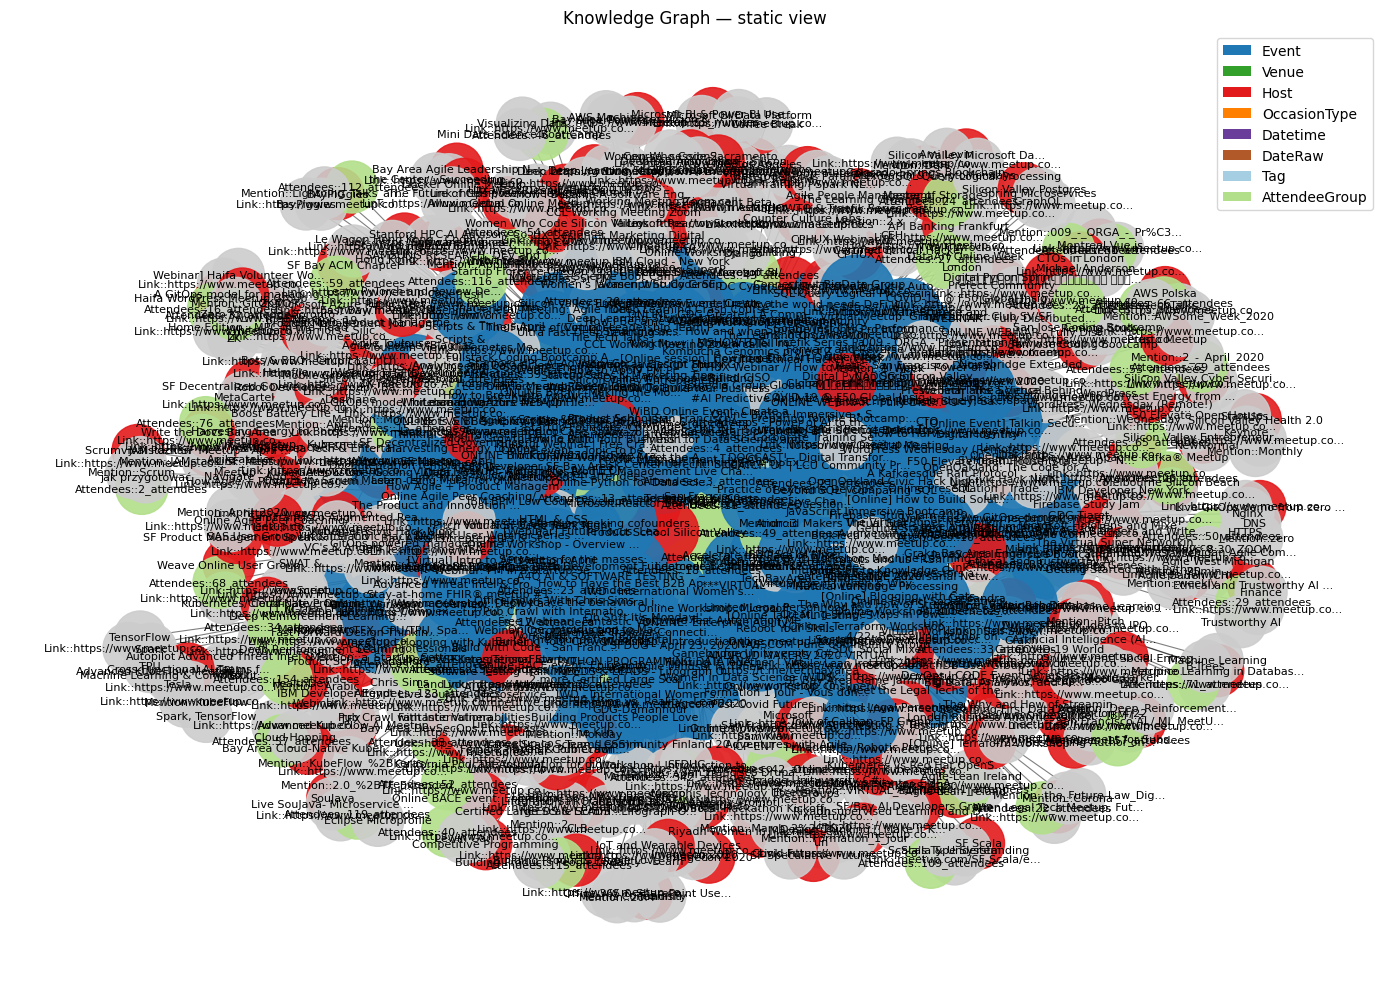

In [30]:
import os
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# try to use existing G, else load from graphml/gexf/json
try:
    G  # noqa: F821
    print("Using in-memory graph G")
except NameError:
    # try common export locations
    loaded = False
    for candidate in ["kg_outputs/kg.graphml", "kg.graphml", "kg_outputs/kg.gexf", "kg.gexf", "kg_outputs/kg.json", "kg.json"]:
        if Path(candidate).exists():
            print("Loading graph from", candidate)
            ext = Path(candidate).suffix.lower()
            if ext == ".graphml":
                G = nx.read_graphml(candidate)
            elif ext == ".gexf":
                G = nx.read_gexf(candidate)
            elif ext == ".json":
                import json
                j = json.load(open(candidate, "r", encoding="utf8"))
                G = nx.MultiDiGraph()
                for n in j["nodes"]:
                    G.add_node(n["id"], **n.get("attrs", {}))
                for e in j["edges"]:
                    src = e["source"]; tgt = e["target"]; attrs = e.get("attrs", {})
                    G.add_edge(src, tgt, **attrs)
            loaded = True
            break
    if not loaded:
        raise FileNotFoundError("No graph variable G found in memory and no kg.graphml/kg.gexf/kg.json found in current folder.")

print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# ---- Configuration (tweak these) ----
figsize = (14, 10)
layout_alg = "spring"   # options: "spring", "kamada_kawai", "shell", "spectral"
label_fontsize = 8
node_size_base = 700    # scale base for node sizes
max_label_len = 30      # shorten labels for clarity

# create position mapping
if layout_alg == "spring":
    pos = nx.spring_layout(G, k=0.8, iterations=120, seed=42)
elif layout_alg == "kamada_kawai":
    pos = nx.kamada_kawai_layout(G)
elif layout_alg == "shell":
    pos = nx.shell_layout(G)
else:
    pos = nx.spring_layout(G, seed=42)

# color nodes by their "type" attribute if present
type_to_color = {
    "Event": "#1f78b4",
    "Venue": "#33a02c",
    "Host": "#e31a1c",
    "OccasionType": "#ff7f00",
    "Datetime": "#6a3d9a",
    "DateRaw": "#b15928",
    "Tag": "#a6cee3",
    "AttendeeGroup": "#b2df8a",
    # fallback color
    "default": "#cccccc"
}

node_colors = []
node_sizes = []
labels = {}
for n, attrs in G.nodes(data=True):
    t = attrs.get("type") or attrs.get("label") or "default"
    color = type_to_color.get(t, type_to_color["default"])
    node_colors.append(color)
    # size proportional to degree (so important nodes stand out)
    deg = max(1, G.degree(n))
    node_sizes.append(node_size_base * (1 + deg**0.6))
    # label (shorten if long)
    label_text = attrs.get("title") or attrs.get("name") or attrs.get("value") or n
    if isinstance(label_text, (dict, list)):
        label_text = str(label_text)
    label_text = str(label_text)
    if len(label_text) > max_label_len:
        label_text = label_text[:max_label_len-3] + "..."
    labels[n] = label_text

# create figure
plt.figure(figsize=figsize)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.5, arrows=False, width=0.8)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=label_fontsize)

# legend
legend_entries = []
seen = set()
for k, col in type_to_color.items():
    if k == "default": continue
    if k in seen: continue
    legend_entries.append(Patch(facecolor=col, label=k))
    seen.add(k)
plt.legend(handles=legend_entries, loc='upper right')

plt.axis("off")
plt.title("Knowledge Graph — static view")
plt.tight_layout()
plt.show()


# We can see if the dataset have all attributes then the graph is way clustered as shown above, attributes like Attendes, Link etc. are creating unncessary problems and making it dense. We remove these columns and generate different KGs for each query and store it.



---



#Approach 2

In [31]:
import os, re, json, zipfile, math
from pathlib import Path
from datetime import datetime
import pandas as pd
import networkx as nx
from rdflib import Graph as RDFGraph, Literal, URIRef, Namespace
from rdflib.namespace import RDF
from dateutil import parser as dateparser
from rapidfuzz import fuzz, process
from tqdm import tqdm
import matplotlib.pyplot as plt

In [33]:
EXCEL_PATH = "//content/sample - Copy.xlsx"   # <--- removed the columns {id, link, attendee}
OUTPUT_BASE = Path("kg_queries_output_2")
OUTPUT_BASE.mkdir(exist_ok=True)
ZIP_OUTPUT = "kg_queries_2.zip"

In [34]:
# How many hops around matched event nodes to include in subgraph
NEIGHBOR_RADIUS = 2

# Fuzzy match threshold (0-100) for text fields used in queries
FUZZY_THRESH = 85

# Layout settings for denser subgraphs (adaptive)
SPRING_ITERS = 200

In [35]:
# Helper functions
def safe_str(x):
    if pd.isna(x):
        return None
    if isinstance(x, (int, float)):
        # keep ints without .0
        if float(x).is_integer():
            return str(int(x))
        return str(x)
    return str(x).strip()

In [36]:
def parse_datetime(date_cell, time_cell=None):
    if (date_cell is None or str(date_cell).strip()=="") and (time_cell is None or str(time_cell).strip()==""):
        return None
    try:
        cand = f"{date_cell} {time_cell}" if time_cell and str(time_cell).strip() else str(date_cell)
        dt = dateparser.parse(cand, fuzzy=True)
        return dt.isoformat()
    except Exception:
        try:
            return dateparser.parse(str(date_cell), fuzzy=True).isoformat()
        except Exception:
            return None

In [37]:
def node_id(kind, value):
    v = str(value).strip().replace(" ", "_").replace("/", "_")[:180]
    return f"{kind}::{v}"

def fuzzy_eq(a, b, thresh=FUZZY_THRESH):
    if a is None or b is None: return False
    return fuzz.token_sort_ratio(str(a), str(b)) >= thresh

# safe RDF-friendly URI fragment
def uri_safe(s):
    return re.sub(r'[^A-Za-z0-9_:-]', '_', str(s))

In [38]:
if not Path(EXCEL_PATH).exists():
    raise FileNotFoundError(f"Excel file not found at {EXCEL_PATH}. Upload it or update EXCEL_PATH.")

df = pd.read_excel(EXCEL_PATH)
print(f"Loaded {len(df)} rows / columns: {list(df.columns)}")

# Detect columns (case-insensitive)
cols_lower = {c.lower(): c for c in df.columns}
def getcol(names):
    for n in names:
        if n.lower() in cols_lower:
            return cols_lower[n.lower()]
    return None

Loaded 220 rows / columns: ['date', 'Venue', 'OccasionType', 'Time', 'Host', 'Event']


In [39]:
col_event = getcol(["event", "title", "name"])
col_date  = getcol(["date", "startdate", "day"])
col_time  = getcol(["time", "starttime"])
col_venue = getcol(["venue", "location", "place"])
col_type  = getcol(["occasiontype", "OccasionType", "type", "category"])
col_host  = getcol(["host", "organizer", "owner"])

In [40]:
# Check required columns
required = [col_date, col_venue, col_type, col_time, col_host, col_event]
if all(c is None for c in required):
    raise ValueError("None of the expected columns were found. Make sure your Excel has any of: date, Venue, OccasionType, Time, Host, Event")

In [41]:
records = []
for idx, row in df.iterrows():
    r = {}
    r['row_idx'] = int(idx)
    r['event'] = safe_str(row[col_event]) if col_event else f"Event_{idx}"
    r['date_raw'] = safe_str(row[col_date]) if col_date else None
    r['time_raw'] = safe_str(row[col_time]) if col_time else None
    r['datetime'] = parse_datetime(r['date_raw'], r['time_raw'])
    r['venue'] = safe_str(row[col_venue]) if col_venue else None
    r['occasion_type'] = safe_str(row[col_type]) if col_type else None
    r['host'] = safe_str(row[col_host]) if col_host else None
    records.append(r)

print(f"Prepared {len(records)} records. Example record:\n", records[:2])

Prepared 220 records. Example record:
 [{'row_idx': 0, 'event': 'Webinar: PM in a Startup Setting by Alexa Product Lead', 'date_raw': '2020-04-20 00:00:00', 'time_raw': '00:00:00', 'datetime': '2020-04-20T00:00:00', 'venue': 'San-Francisco', 'occasion_type': 'Technology,business', 'host': 'Product School Bangalore'}, {'row_idx': 1, 'event': 'Live SouJava- Microservice Patterns - Implemented by Eclipse Microprofile', 'date_raw': '2020-04-20 00:00:00', 'time_raw': '07:00:00', 'datetime': '2020-04-20T07:00:00', 'venue': 'San-Francisco', 'occasion_type': 'Technology,business', 'host': 'SouJava'}]


Hee the output seems way better:

 `[{'row_idx': 0, 'event': 'Webinar: PM in a Startup Setting by Alexa Product Lead', 'date_raw': '2020-04-20 00:00:00', 'time_raw': '00:00:00', 'datetime': '2020-04-20T00:00:00', 'venue': 'San-Francisco', 'occasion_type': 'Technology,business', 'host': 'Product School Bangalore'}, `

 `{'row_idx': 1, 'event': 'Live SouJava- Microservice Patterns - Implemented by Eclipse Microprofile', 'date_raw': '2020-04-20 00:00:00', 'time_raw': '07:00:00', 'datetime': '2020-04-20T07:00:00', 'venue': 'San-Francisco', 'occasion_type': 'Technology,business', 'host': 'SouJava'}]`


In [42]:
# 3) Fuzzy dedupe canonicalization for host & venue (helps reduce nodes)
# Build list of unique hosts and venues then canonicalize first-seen

def canonicalize(values, threshold=88):
    mapping = {}
    canonicals = []
    for v in values:
        if v is None: continue
        found = None
        for c in canonicals:
            if fuzz.token_sort_ratio(v, c) >= threshold:
                found = c
                break
        if found is None:
            canonicals.append(v)
            mapping[v] = v
        else:
            mapping[v] = found
    return mapping

hosts = list({r['host'] for r in records if r['host']})
venues = list({r['venue'] for r in records if r['venue']})
host_map = canonicalize(hosts, threshold=88)
venue_map = canonicalize(venues, threshold=88)

# Build the global KG (MultiDiGraph)

In [43]:
G = nx.MultiDiGraph()
for r in records:
    # event node: make unique per row to avoid merging different events with same title
    event_node = node_id("Event", f"{r['row_idx']}_{r['event']}")
    G.add_node(event_node, type="Event", title=r['event'], datetime=r['datetime'], date_raw=r['date_raw'], time_raw=r['time_raw'])

    # Date/Datetime node
    if r['datetime']:
        dt_node = node_id("Date", r['datetime'])
        G.add_node(dt_node, type="Date", value=r['datetime'])
        G.add_edge(event_node, dt_node, relation="Event-occursOn-Date")
    elif r['date_raw']:
        dr_node = node_id("DateRaw", r['date_raw'])
        G.add_node(dr_node, type="DateRaw", value=r['date_raw'])
        G.add_edge(event_node, dr_node, relation="Event-occursOn-Date")

    # Time node (if parsed separately)
    if r['time_raw']:
        t_node = node_id("Time", r['time_raw'])
        G.add_node(t_node, type="Time", value=r['time_raw'])
        G.add_edge(event_node, t_node, relation="Event-scheduledAt-Time")

    # Venue node
    if r['venue']:
        vc = venue_map.get(r['venue'], r['venue'])
        v_node = node_id("Venue", vc)
        G.add_node(v_node, type="Venue", name=vc)
        G.add_edge(event_node, v_node, relation="Event-heldAt-Venue")

    # Host node
    if r['host']:
        hc = host_map.get(r['host'], r['host'])
        h_node = node_id("Host", hc)
        G.add_node(h_node, type="Host", name=hc)
        G.add_edge(event_node, h_node, relation="Event-hostedBy-Host")

    # OccasionType node
    if r['occasion_type']:
        t_node = node_id("OccasionType", r['occasion_type'])
        G.add_node(t_node, type="OccasionType", name=r['occasion_type'])
        G.add_edge(event_node, t_node, relation="Event-for-OccasionType")

print(f"Global KG built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Global KG built: 553 nodes, 1100 edges


In [44]:
QUERIES = [
    {"host": "Product School Bangalore"},
    {"venue": "San-Francisco"},
    {"occasion_type": "Technology"},
    {"event_keyword": "Microservice"},
    {"date_from": "2020-04-20", "date_to": "2020-04-21"}  # date range example
]

In [46]:
def find_matching_event_nodes(G, query):
    # We'll search event nodes' attributes stored in node data
    event_nodes = [n for n,d in G.nodes(data=True) if d.get("type")=="Event"]
    matched = set()
    # Precompute attribute access
    if 'host' in query:
        host_q = str(query['host'])
        # Find host nodes that fuzzily match the query (Host nodes)
        host_nodes = [n for n,d in G.nodes(data=True) if d.get("type")=="Host"]
        matched_hosts = []
        for hn in host_nodes:
            if fuzz.token_sort_ratio(host_q, d := G.nodes[hn].get("name","")) >= FUZZY_THRESH:
                matched_hosts.append(hn)
        # all events connected to these hosts
        for mh in matched_hosts:
            for u,v,k in G.in_edges(mh, keys=True):
                matched.add(u)
    if 'venue' in query:
        venue_q = str(query['venue'])
        venue_nodes = [n for n,d in G.nodes(data=True) if d.get("type")=="Venue"]
        matched_venues = []
        for vn in venue_nodes:
            if fuzz.token_sort_ratio(venue_q, G.nodes[vn].get("name","")) >= FUZZY_THRESH:
                matched_venues.append(vn)
        for mv in matched_venues:
            for u,v,k in G.in_edges(mv, keys=True):
                matched.add(u)
    if 'occasion_type' in query:
        t_q = str(query['occasion_type'])
        t_nodes = [n for n,d in G.nodes(data=True) if d.get("type")=="OccasionType"]
        for tn in t_nodes:
            if fuzz.token_sort_ratio(t_q, G.nodes[tn].get("name","")) >= FUZZY_THRESH:
                for u,v,k in G.in_edges(tn, keys=True):
                    matched.add(u)
    if 'event_keyword' in query:
        ek = str(query['event_keyword']).lower()
        for n in event_nodes:
            title = (G.nodes[n].get("title") or "").lower()
            if ek in title or fuzz.partial_ratio(ek, title) >= FUZZY_THRESH:
                matched.add(n)
    # date / date range
    if 'date' in query:
        try:
            d_q = dateparser.parse(query['date']).date()
            for n in event_nodes:
                dt_raw = G.nodes[n].get("datetime") or G.nodes[n].get("date_raw")
                if dt_raw:
                    try:
                        dnode = dateparser.parse(dt_raw).date()
                        if dnode == d_q:
                            matched.add(n)
                    except Exception:
                        pass
        except Exception:
            pass
    if 'date_from' in query or 'date_to' in query:
        dfq = dateparser.parse(query['date_from']).date() if 'date_from' in query else None
        dtq = dateparser.parse(query['date_to']).date() if 'date_to' in query else None
        for n in event_nodes:
            dt_raw = G.nodes[n].get("datetime") or G.nodes[n].get("date_raw")
            if not dt_raw: continue
            try:
                dnode = dateparser.parse(dt_raw).date()
                if dfq and dnode < dfq: continue
                if dtq and dnode > dtq: continue
                matched.add(n)
            except Exception:
                continue
    # fallback: if no matched nodes were found, attempt fuzzy match on event title from any provided text fields in query
    if not matched and any(k in query for k in ("host","venue","occasion_type","event_keyword")):
        # try scanning event titles for fuzzy matches against any textual field in query
        text_cands = " ".join([str(v) for k,v in query.items() if isinstance(v, str)])
        if text_cands.strip():
            for n in event_nodes:
                title = (G.nodes[n].get("title") or "")
                if fuzz.token_sort_ratio(text_cands, title) >= FUZZY_THRESH:
                    matched.add(n)
    return list(matched)

#  Export helpers for subgraph

In [47]:
def export_graph_formats(subg, folder_path):
    folder_path = Path(folder_path)
    folder_path.mkdir(parents=True, exist_ok=True)
    # GraphML (convert to DiGraph to avoid GraphML multi-edge limitations)
    g_digraph = nx.DiGraph()
    g_digraph.add_nodes_from(subg.nodes(data=True))
    g_digraph.add_edges_from([(u,v,dict(d)) for u,v,k,d in subg.edges(keys=True, data=True)])
    nx.write_graphml(g_digraph, str(folder_path / "kg.graphml"))
    # GEXF (supports multi-edges)
    nx.write_gexf(subg, str(folder_path / "kg.gexf"))
    # JSON (simple nodes/edges list)
    export_json = {"nodes": [], "edges": []}
    for n,attrs in subg.nodes(data=True):
        export_json["nodes"].append({"id": n, "attrs": attrs})
    for u,v,k,attrs in subg.edges(keys=True, data=True):
        export_json["edges"].append({"source":u, "target":v, "key":k, "attrs": attrs})
    with open(folder_path / "kg.json", "w", encoding="utf8") as f:
        json.dump(export_json, f, indent=2, ensure_ascii=False)
    # edges CSV
    rows=[]
    for u,v,k,attrs in subg.edges(keys=True, data=True):
        row = {"source":u, "target":v, "relation": attrs.get("relation")}
        row.update({f"edge_{kk}":vv for kk,vv in attrs.items() if kk!="relation"})
        rows.append(row)
    pd.DataFrame(rows).to_csv(folder_path / "kg_edges.csv", index=False)
    # RDF Turtle
    RDF_NS = Namespace("http://example.org/kg/")
    rkg = RDFGraph()
    rkg.bind("kg", RDF_NS)
    for n,attrs in subg.nodes(data=True):
        subj = URIRef(RDF_NS + uri_safe(n))
        rkg.add((subj, RDF.type, Literal(attrs.get("type","Node"))))
        for k,v in attrs.items():
            try:
                rkg.add((subj, RDF_NS[k], Literal(str(v))))
            except Exception:
                pass
    for u,v,k,attrs in subg.edges(keys=True, data=True):
        subj = URIRef(RDF_NS + uri_safe(u))
        obj = URIRef(RDF_NS + uri_safe(v))
        pred_label = attrs.get("relation") or "relatedTo"
        pred = RDF_NS[pred_label.replace(" ", "_")]
        rkg.add((subj, pred, obj))
    rkg.serialize(destination=str(folder_path / "kg.ttl"), format="turtle")

In [48]:
def export_png(subg, folder_path, title_text="KG Subgraph", figsize=(14,10)):
    folder_path = Path(folder_path)
    # adaptive layout: choose k based on node count for better spacing
    n = subg.number_of_nodes()
    if n <= 1:
        pos = {n_: (0,0) for n_ in subg.nodes()}
    else:
        k = 1.0
        # scale k with sqrt(num_nodes) so larger graphs space out more
        k = 0.8 * math.sqrt(max(1, n)) / (math.log(max(2,n)))
        pos = nx.spring_layout(subg, k=k, iterations=SPRING_ITERS, seed=42)
    # prepare drawing parameters
    plt.figure(figsize=figsize)
    # color nodes by type attribute
    type_to_color = {
        "Event": "#1f78b4", "Venue": "#33a02c", "Host": "#e31a1c",
        "OccasionType": "#ff7f00", "Date": "#6a3d9a", "Time":"#b15928", "default":"#999999"
    }
    node_colors=[]
    node_sizes=[]
    labels={}
    max_label_len = 30
    base_size = 600
    for n,attrs in subg.nodes(data=True):
        t = attrs.get("type") or "default"
        node_colors.append(type_to_color.get(t, type_to_color["default"]))
        deg = max(1, subg.degree(n))
        node_sizes.append(base_size * (1 + math.log(deg+1)))
        lab = attrs.get("title") or attrs.get("name") or attrs.get("value") or n
        lab = str(lab)
        if len(lab)>max_label_len:
            lab = lab[:max_label_len-3] + "..."
        labels[n] = lab
    nx.draw_networkx_nodes(subg, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(subg, pos, alpha=0.6, arrows=False, width=0.8)
    nx.draw_networkx_labels(subg, pos, labels=labels, font_size=8)
    plt.title(title_text)
    plt.axis("off")
    out_png = folder_path / "kg_preview.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

In [51]:
# For each query: build subgraph, export, visualize

all_query_folders = []
for i, q in enumerate(QUERIES):
    print(f"\nProcessing query {i+1}/{len(QUERIES)}: {q}")
    matched_events = find_matching_event_nodes(G, q)
    if not matched_events:
        print(" > No matching events found for this query. Skipping.")
        continue
    # Build subgraph: start with matched events, add neighbors up to NEIGHBOR_RADIUS hops
    nodes_to_include = set()
    for ev in matched_events:
        # ego_graph radius NEIGHBOR_RADIUS: includes ev + neighbors up to N hops
        ego = nx.ego_graph(G, ev, radius=NEIGHBOR_RADIUS)
        nodes_to_include.update(ego.nodes())
    subg = G.subgraph(nodes_to_include).copy()
    # make folder for this query
    # name folder based on index + short repr of query
    qname = "_".join([f"{k}-{str(v)[:30].replace(' ','_')}" for k,v in q.items()])
    qfolder = OUTPUT_BASE / f"query_{i+1}__{qname}"
    qfolder.mkdir(parents=True, exist_ok=True)
    # export formats
    export_graph_formats(subg, qfolder)
    export_png(subg, qfolder, title_text=f"KG Subgraph Query {i+1}")
    # save a small metadata + list of included nodes
    meta = {
        "query": q,
        "matched_event_count": len(matched_events),
        "subgraph_nodes": subg.number_of_nodes(),
        "subgraph_edges": subg.number_of_edges(),
        "matched_event_nodes": matched_events
    }
    with open(qfolder / "metadata.json", "w", encoding="utf8") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)
    all_query_folders.append(qfolder)
    print(f" > Exported subgraph for query {i+1} to {qfolder} ({subg.number_of_nodes()} nodes)")



Processing query 1/5: {'host': 'Product School Bangalore'}
 > Exported subgraph for query 1 to kg_queries_output_2/query_1__host-Product_School_Bangalore (6 nodes)

Processing query 2/5: {'venue': 'San-Francisco'}


/tmp/ipython-input-137485516.py:41: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  plt.savefig(out_png, dpi=200)
/tmp/ipython-input-137485516.py:41: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.savefig(out_png, dpi=200)
/tmp/ipython-input-137485516.py:41: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I}) missing from font(s) DejaVu Sans.
  plt.savefig(out_png, dpi=200)
/tmp/ipython-input-137485516.py:41: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(out_png, dpi=200)
/tmp/ipython-input-137485516.py:41: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu Sans.
  plt.savefig(out_png, dpi=200)
/tmp/ipython-input-137485516.py:41: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.savefig(out_png, dpi=200)
/tmp/ipython-input-137485516.py:41: UserWarning: Glyph 12491 (\N

 > Exported subgraph for query 2 to kg_queries_output_2/query_2__venue-San-Francisco (553 nodes)

Processing query 3/5: {'occasion_type': 'Technology'}
 > No matching events found for this query. Skipping.

Processing query 4/5: {'event_keyword': 'Microservice'}
 > Exported subgraph for query 4 to kg_queries_output_2/query_4__event_keyword-Microservice (10 nodes)

Processing query 5/5: {'date_from': '2020-04-20', 'date_to': '2020-04-21'}
 > Exported subgraph for query 5 to kg_queries_output_2/query_5__date_from-2020-04-20_date_to-2020-04-21 (291 nodes)


Results:

```
Processing query 1/5: {'host': 'Product School Bangalore'}
 > Exported subgraph for query 1 to kg_queries_output_2/query_1__host-Product_School_Bangalore (6 nodes)
```
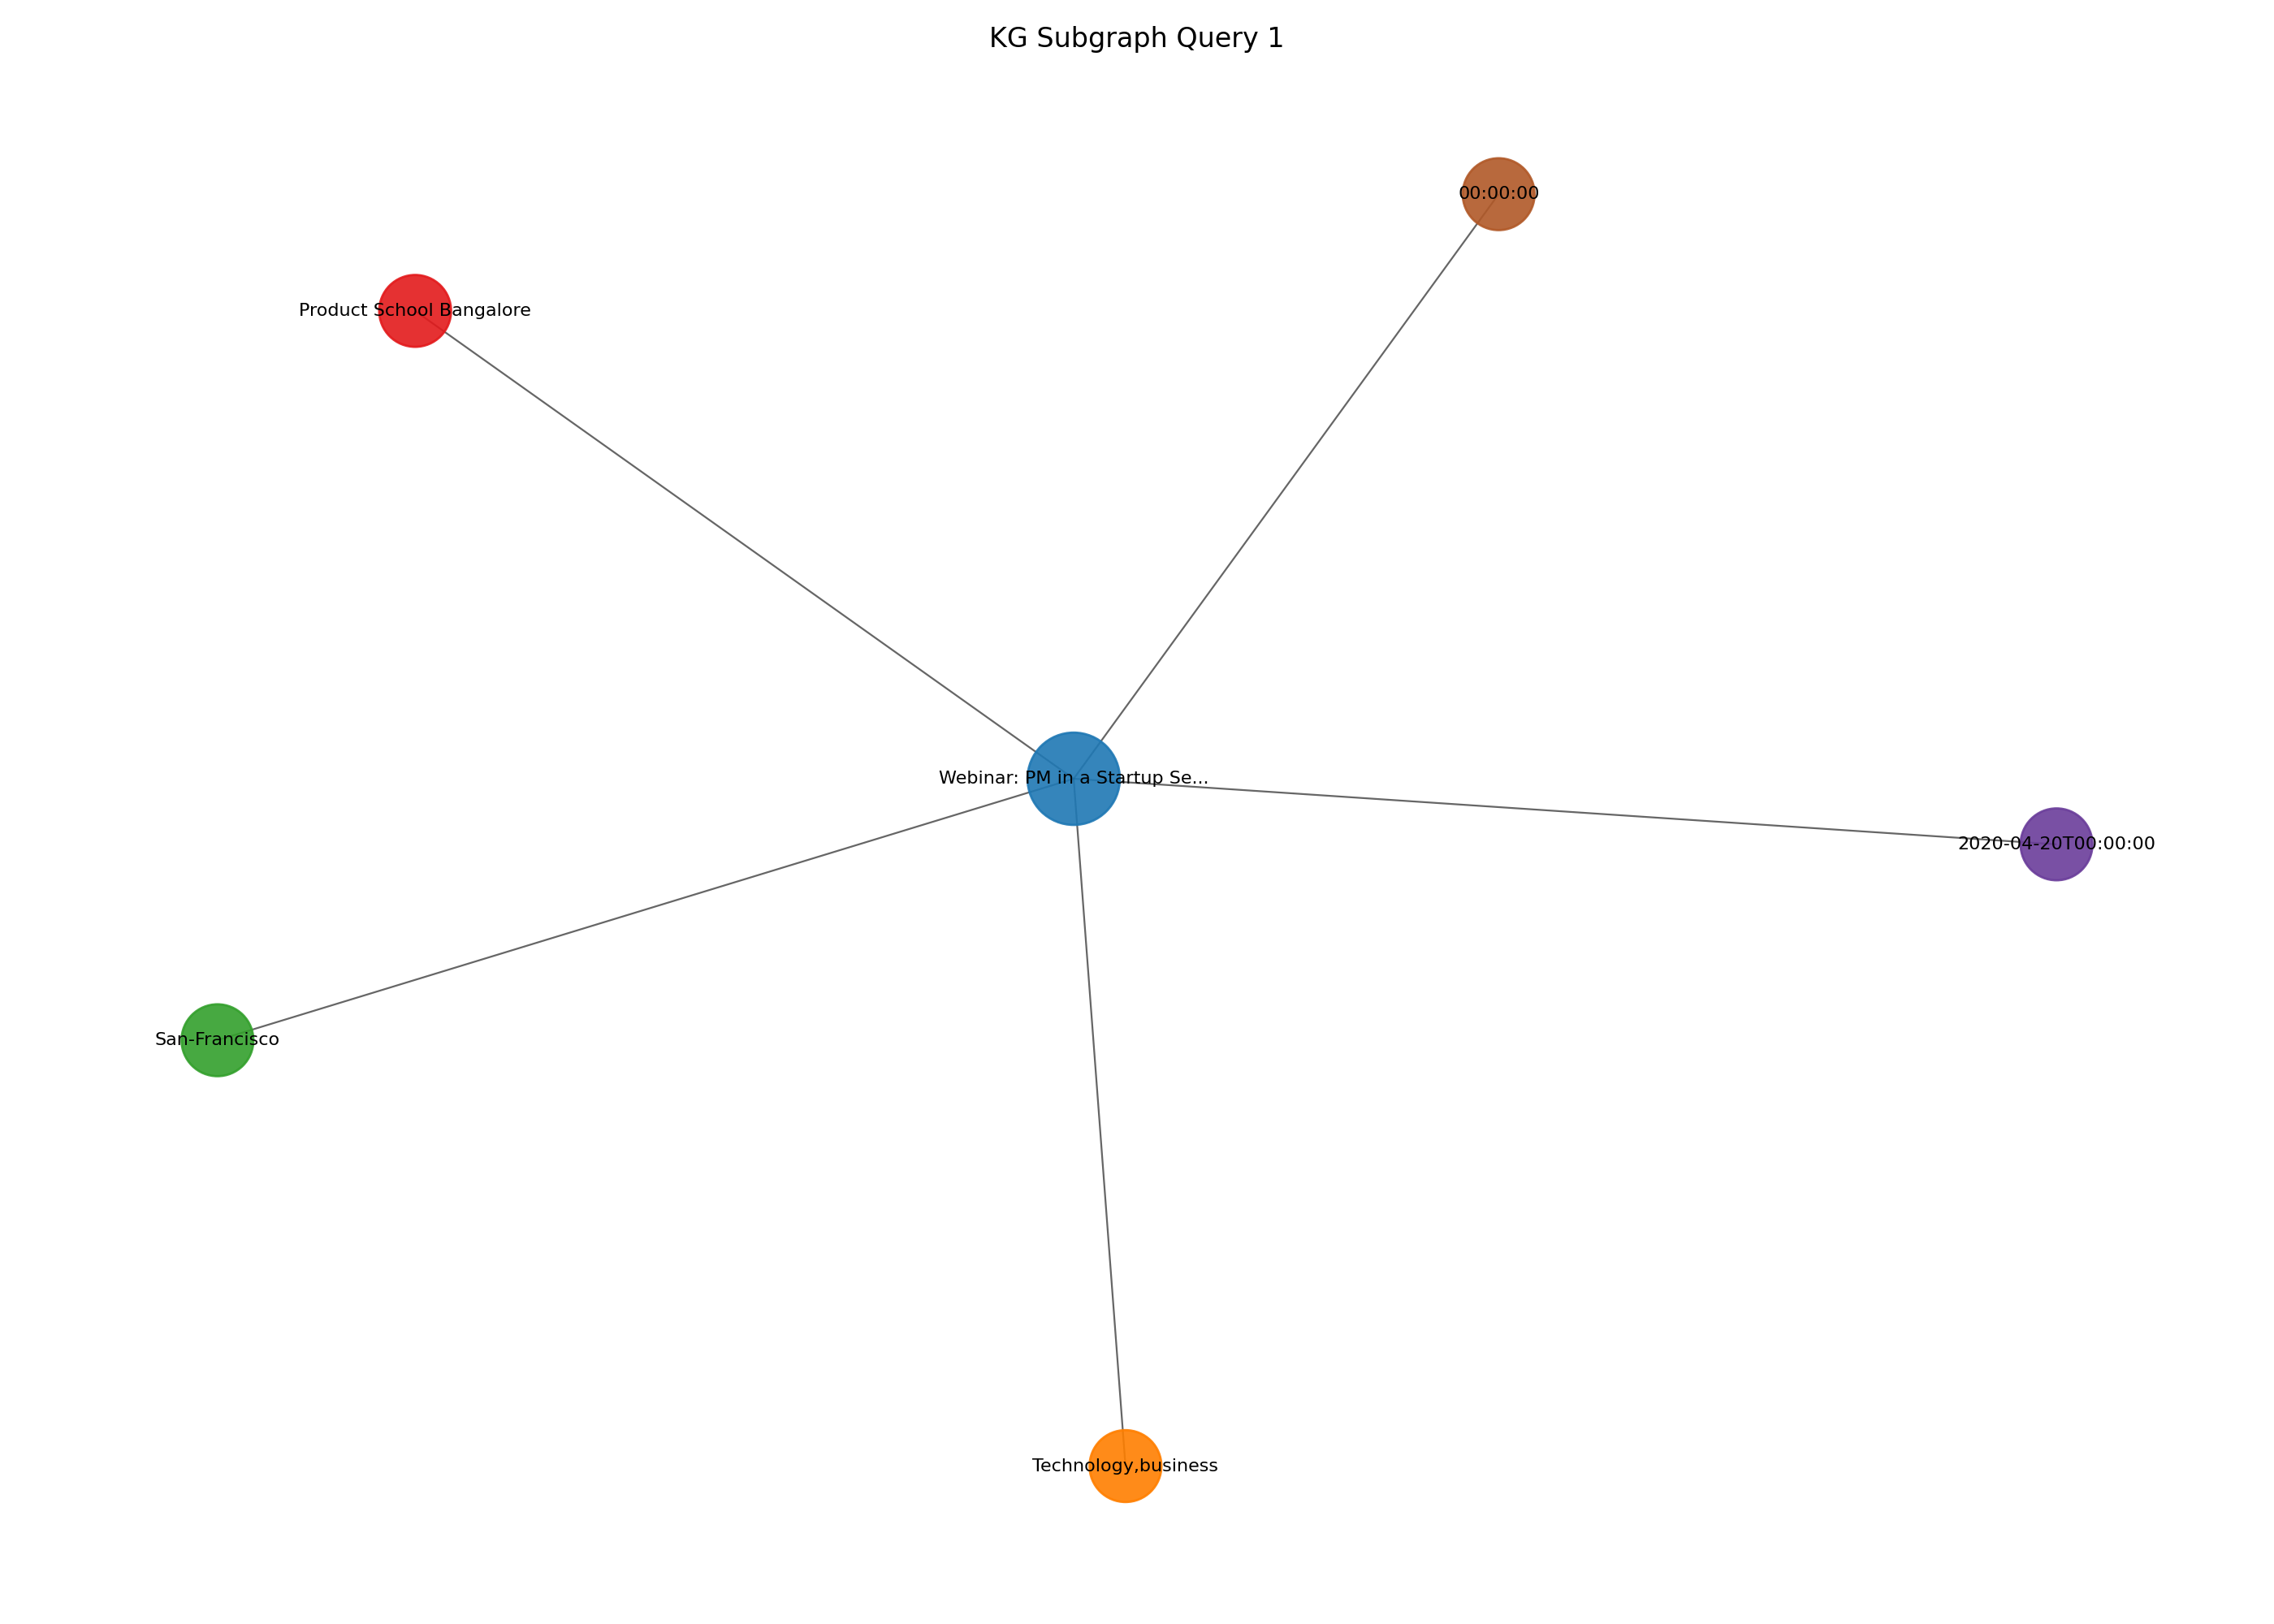
```
Processing query 2/5: {'venue': 'San-Francisco'}
> Exported subgraph for query 2 to kg_queries_output_2/query_2__venue-San-Francisco (553 nodes)
```

```
Processing query 3/5: {'occasion_type': 'Technology'}
 > No matching events found for this query. Skipping.
```

```
Processing query 4/5: {'event_keyword': 'Microservice'}
 > Exported subgraph for query 4 to kg_queries_output_2/query_4__event_keyword-Microservice (10 nodes)
```

```
Processing query 5/5: {'date_from': '2020-04-20', 'date_to': '2020-04-21'}
 > Exported subgraph for query 5 to kg_queries_output_2/query_5__date_from-2020-04-20_date_to-2020-04-21 (291 nodes)
```



In [52]:
if Path(ZIP_OUTPUT).exists():
    Path(ZIP_OUTPUT).unlink()
with zipfile.ZipFile(ZIP_OUTPUT, "w", zipfile.ZIP_DEFLATED) as zf:
    for qf in all_query_folders:
        for p in qf.rglob("*"):
            if p.is_file():
                arcname = str(p.relative_to(OUTPUT_BASE))
                zf.write(p, arcname=arcname)
print(f"\nAll query outputs zipped into: {ZIP_OUTPUT}")
print("Per-query folders created:", [str(x) for x in all_query_folders])


All query outputs zipped into: kg_queries_2.zip
Per-query folders created: ['kg_queries_output_2/query_1__host-Product_School_Bangalore', 'kg_queries_output_2/query_2__venue-San-Francisco', 'kg_queries_output_2/query_4__event_keyword-Microservice', 'kg_queries_output_2/query_5__date_from-2020-04-20_date_to-2020-04-21']
